# Neuronales Netz mit Keras

In diesem Notebook wird ein neuronales Netz trainiert, um Kleidungsstücke, wie Turnschuhe und Hemden, zu klassifizieren (Datensatz von Zalando:https://github.com/zalandoresearch/fashion-mnist). Es wird [tf.keras](https://keras.io/) verwendet, eine API zum Erstellen und Trainieren von Modellen in TensorFlow.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

Mal kurz checken, welche Tensorflow Version verwendet wird. In dem Test  wurde 1.13.1 verwendet.
Eine neue Tensorflow Version laesst sich in einer Jupyter-Notebook-Umgebung evtl mit

!pip install tensorflow version>=1.13.2

In [2]:
print(tf.__version__)

2.2.0


## Importieren des Fashion-Datensatzes

Hier wird der [Fashion MNIST-Datensatz](https://github.com/zalandoresearch/fashion-mnist) von Zalando (MIT Licensse) verwendet. Dieser enthält 70.000 Graustufenbilder in 10 Kategorien ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'). Die Bilder zeigen einzelne Kleidungsstücke mit niedriger Auflösung (28 x 28 Pixel), wie hier zu sehen:

![Sample](fashion-mnist-sprite.png)

Laden des Datensatzes geht über Keras-Funktionen:

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


4423680/4422102 [==============================] - 0s 0us/step


In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Datenmenge und Formate

Lassen Sie uns zunächst das Format des Datensatzes erkunden, bevor Sie das Modell trainieren. Das folgende zeigt, dass sich 60.000 Bilder im Trainingsset befinden, wobei jedes Bild als 28 x 28 Pixel dargestellt wird:

In [5]:
train_images.shape


(60000, 28, 28)

Glücklicherweise gibt es wohl auch genauso viele Labels :-):

In [6]:
len(train_labels)

60000

Testdaten sehen genauso aus und sind entsprechend gelabelt:

In [7]:
test_images.shape

(10000, 28, 28)

In [8]:
len(test_images)

10000

# Daten vorverarbeiten

Die Daten müssen vor dem Training des Netzwerks vorverarbeitet werden. Wenn Sie das erste Bild im Trainingssatz untersuchen, werden Sie feststellen, dass die Pixelwerte im Bereich von 0 bis 255 liegen:

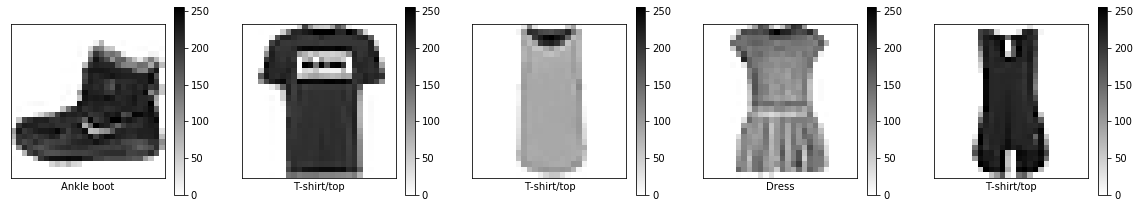

In [9]:
plt.figure(figsize=(20,20))

for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
    plt.colorbar()
plt.show()



Wir skalieren diese Werte auf einen Bereich von 0 bis 1, bevor wir sie im neuronalen Netz verwenden. Dazu dividieren wir die Werte durch 255. Es ist wichtig, dass der **Trainingssatz** und der **Testsatz** auf dieselbe Weise vorverarbeitet werden:

In [10]:
train_images = train_images / 255.0

test_images = test_images / 255.0


Eine kurze Kontrolle der ersten 25 Bilder des Trainingssatzes. Hierzu Bild und Klassenname anzeigen

ipykernel_launcher:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


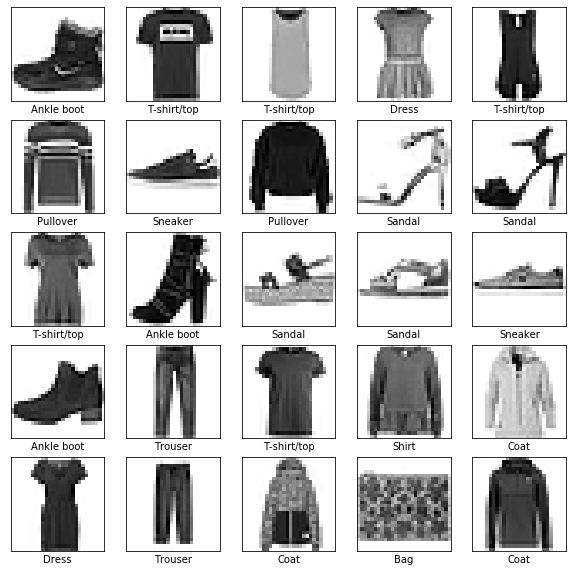

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(5,5,i+1)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()


## Erstellen des Modells

Um ein neuronales Netz zu erstellen, müssen Sie die Schichten des Modells konfigurieren und dann das Modell kompilieren. 

### Einrichten der Schichten 

Der Grundbaustein eines neuronalen Netzes sind die einzelnen Schichten (Layer). Layer extrahieren Feature aus den Daten. Zunächst werden beim Deep Learning einzelne schichten verkettet. 

1. Layer: Der erste Layer in diesem Netz, tf.keras.layers.Flatten, wandelt das Format der Bilder von einem 2d-Array (von 28 mal 28 Pixel) in ein 1d-Array von 28 * 28 = 784 Pixel um. Stellen Sie sich diese Ebene so vor, dass Sie Pixelreihen im Bild entstapeln und diese aneinanderreihen. Diese Ebene hat keine zu lernenden Parameter; Es formatiert nur die Daten. 

2. Layer : Nachdem die Pixel abgeflacht sind, besteht das Netzwerk aus einer Folge von zwei tf.keras.layers.Dense-Layern. Dies sind _dich_ verbundene oder vollständig verbundene neurale Schichten. Die erste dichte Schicht hat 128 Knoten (oder Neuronen). Diese Schicht verwendet als Aktivierungsfunktion die reLU-Aktivierung. Alternativen waeren sigmoid oder tanh.

3. Layer (Output): Die zweite (und letzte) Schicht ist eine 10-Knoten-Softmax-Schicht. Diese gibt ein Array von 10 Wahrscheinlichkeitsbewertungen zurück, die sich zu 1 summieren. Jeder Knoten enthält eine Bewertung, die die Wahrscheinlichkeit angibt, dass das aktuelle Bild zu einer der 10 Klassen gehört.


In [12]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])


### Modell kompilieren 

Bevor das Modell für das Training bereit ist, sind einige weitere Einstellungen erforderlich. Diese werden während des Kompilierungsschritts des Modells hinzugefügt:

- Verlustfunktion - Hier wird die Genauigkeit des Modells während des Trainings gemessen. Wir möchten diese Funktion minimieren, um das Modell in die richtige Richtung zu "lenken". Mögliche Werte sind: [mean_squared_error, mean_absolute_error, mean_squared_logarithmic_error ..](https://keras.io/losses/) 

- Optimierer: Auf diese Weise wird das Modell basierend auf den angezeigten Daten und seiner Verlustfunktion aktualisiert. Mögliche Werte sind: [Adam, Adamax, SGD, ...](https://keras.io/optimizers/)

- Metriken - Zum Überwachen der Schulungs- und Testschritte. Das folgende Beispiel verwendet die Genauigkeit, den Bruchteil der Bilder, die korrekt klassifiziert werden. Die MEtrik wird nicht beim Trainieren, sondern beim Testen.

In [13]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


## Trainieren des Modells 

Zum Traininern werde die Training- und Testdaten dem Modell übergeben - in diesem Beispiel die Arrays train_images und train_labels. Das Modell lernt, Bilder und Beschriftungen zu verknüpfen. Mit der Metric-Function treffen wir Vorhersagen über ein Test-Set - in diesem Beispiel das Array test_images. Wir überprüfen, ob die Vorhersagen mit den Bezeichnungen aus dem Array test_labels übereinstimmen. Um mit dem Training zu beginnen, rufen Sie die model.fit-Methode auf - das Modell ist an die Trainingsdaten angepasst:

In [14]:
model.fit(train_images, train_labels, epochs=5)


Epoch 1/5
1875/1875 [==============================] - 1s 747us/step - loss: 0.4987 - accuracy: 0.8250
Epoch 2/5
1875/1875 [==============================] - 1s 729us/step - loss: 0.3769 - accuracy: 0.8642
Epoch 3/5
1875/1875 [==============================] - 1s 749us/step - loss: 0.3383 - accuracy: 0.8763
Epoch 4/5
1875/1875 [==============================] - 1s 766us/step - loss: 0.3137 - accuracy: 0.8861
Epoch 5/5
1875/1875 [==============================] - 1s 754us/step - loss: 0.2976 - accuracy: 0.8907


Mit evaluate lässt sich das trainierte Modell nun gegen den Test-Datensatz evaluieren:

In [15]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)



313/313 [==============================] - 0s 872us/step - loss: 0.3645 - accuracy: 0.8699
Test accuracy: 0.8698999881744385


## Mehr Tests

Was gibt uns das Resultat nun?

Im Prinzip ist das Modell nun in der Lage bisher nicht gesehene Bilder zu klassifizieren, sprich einer der Klassen zuzuordnen, jeweils mit einer entsprechenden Konfidenz versehen. Das ist ein Wert zwischen 0...1, der das Vertrauen der Vorhersage angibt (kann als Prozentwert interpretiert werden!).

In [16]:
predictions = model.predict(test_images)


Pickt man das erste Bild heraus und schaut sich die Prediction an, so zeigt sich:

In [17]:
predictions[0]


array([1.4709202e-06, 3.9211878e-07, 2.0230758e-07, 1.1679506e-06,
       5.5837603e-07, 1.6106588e-03, 2.8647246e-06, 7.6998174e-02,
       3.5624016e-05, 9.2134887e-01], dtype=float32)

In [18]:
np.argmax(predictions[0])


9

In [19]:
test_labels[0]


9

Ein paar Hilfsfunktionen zum Anzeigen des Ergbenisses:

In [20]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


Angewendet auf unser erstes Bild:

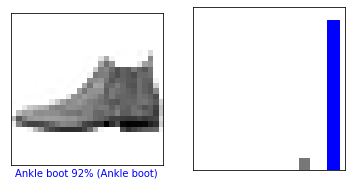

In [21]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()


Bei Bild Nummer 13 sieht das anders aus:

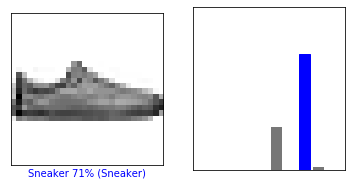

In [22]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()


Und noch die ersten 15 Bilder:

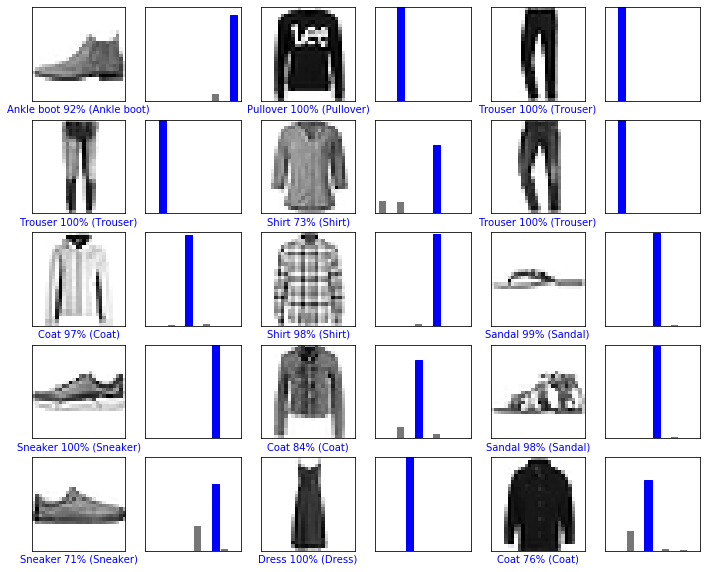

In [23]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()


(taken from https://www.tensorflow.org/tutorials/keras/basic_classification)